In [2]:
#随机森林的重要应用就是填补缺失值
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.impute import SimpleImputer#专门用来填补缺失值的类
from sklearn.ensemble import RandomForestRegressor
#开始的时候不太确定交叉验证，先导进去，最后实际没有用到
from sklearn.model_selection import cross_val_score

In [3]:
dataset = load_boston()
dataset.data.shape

E:\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.
    :fu

(506, 13)

In [4]:
#总共506*13=6578个数据
X_full, y_full = dataset.data, dataset.target

In [5]:
X_full

array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]])

In [6]:
y_full

array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 18.7, 16. , 22.2, 25. , 33. , 23.5,
       19.4, 22. , 17.4, 20.9, 24.2, 21.7, 22.8, 23.4, 24.1, 21.4, 20. ,
       20.8, 21.2, 20.3, 28. , 23.9, 24.8, 22.9, 23.9, 26.6, 22.5, 22.2,
       23.6, 28.7, 22.6, 22. , 22.9, 25. , 20.6, 28.4, 21.4, 38.7, 43.8,
       33.2, 27.5, 26.5, 18.6, 19.3, 20.1, 19.5, 19.5, 20.4, 19.8, 19.4,
       21.7, 22.8, 18.8, 18.7, 18.5, 18.3, 21.2, 19.2, 20.4, 19.3, 22. ,
       20.3, 20.5, 17.3, 18.8, 21.4, 15.7, 16.2, 18. , 14.3, 19.2, 19.6,
       23. , 18.4, 15.6, 18.1, 17.4, 17.1, 13.3, 17.8, 14. , 14.4, 13.4,
       15.6, 11.8, 13.8, 15.6, 14.6, 17.8, 15.4, 21

In [7]:
#样本数量和标签数量
n_samples = X_full.shape[0]
n_features = X_full.shape[1]

In [8]:
#首先确定我们希望放入的缺失数据的比例，在这里我们假设是50%，那总共就要有3289个数据缺失

rng = np.random.RandomState(0)#确认一种随机模式
missing_rate = 0.5
n_missing_samples = int(np.floor(n_samples * n_features * missing_rate))#n_missing_samples=3289
#np.floor向下取整，返回.0格式的浮点数，防止小数导致的意外情况

In [9]:
#所有数据要随机遍布在数据集的各行各列当中，而一个缺失的数据会需要一个行索引和一个列索引
#如果能够创造一个数组，包含3289个分布在0~506中间的行索引，和3289个分布在0~13之间的列索引，那我们就可
#以利用索引来为数据中的任意3289个位置赋空值
#然后我们用0，均值和随机森林来填写这些缺失值，然后查看回归的结果如何

missing_features = rng.randint(0,n_features,n_missing_samples)
#请在上限和下限之间取出n个整数

# numpy.random.randint(low, high=None, size=None, dtype='l')
# low : int 
# 产生随机数的最小值
# high : int, optional 
# 给随机数设置个上限，即产生的随机数必须小于high
# size : int or tuple of ints, optional 
# 输出的大小，可以是整数，或者元组
missing_samples = rng.randint(0,n_samples,n_missing_samples)

#missing_samples = rng.choice(dataset.data.shape[0],n_missing_samples,replace=False)
#我们现在采样了3289个数据，远远超过我们的样本量506，所以我们使用随机抽取的函数randint。但如果我们需要
#的数据量小于我们的样本量506，那我们可以采用np.random.choice来抽样，choice会随机抽取不重复的随机数，
#因此可以帮助我们让数据更加分散，确保数据不会集中在一些行中

In [10]:
len(missing_features)

3289

In [11]:
missing_samples#len也是3289

array([150, 125,  28, ..., 132, 456, 402])

In [12]:
#先复制一下full值，再搞缺失值
X_missing = X_full.copy()#复制
y_missing = y_full.copy()
X_missing[missing_samples,missing_features] = np.nan#缺失值直接补成空值

In [13]:
X_missing = pd.DataFrame(X_missing)
#转换成DataFrame是为了后续方便各种操作，numpy对矩阵的运算速度快到拯救人生，但是在索引等功能上却不如
#pandas来得好用
X_missing

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,69.1,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,91.0,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,89.3,NaN,1.0,NaN,21.0,393.45,6.48


In [14]:
#使用均值进行填补
from sklearn.impute import SimpleImputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')#实例化
X_missing_mean = imp_mean.fit_transform(X_missing) #训练fit+导出predict>>> 特殊的接口fit_transform

In [15]:
pd.DataFrame(X_missing_mean).isnull().sum()#判断数据中是否还有缺失值

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [16]:
#使用0进行填补
imp_0 = SimpleImputer(missing_values=np.nan, strategy="constant",fill_value=0)
X_missing_0 = imp_0.fit_transform(X_missing)
pd.DataFrame(X_missing_0).isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [17]:
##随机森林填补缺失值
#对于一个有n个特征的数据来说，其中特征T有缺失值，我们就把特征T当做标签，其它n-1个特征
#和原本的标签组成新的特征矩阵。那对于T来说，它没有缺失的部分，就是我们的Y_train,这部分
#数据既有标签也有特征，而它确实的部分，只有特征没有标签，就是我们需要预测的部分

#随机森林从缺失最少的开始填补，遍历所有特征之后，数据就完整，就没有缺失值了

X_missing_reg = X_missing.copy()
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values
# 找出数据集中，缺失值从小到大排列的特征们的顺序

In [18]:
#返回每列（每一个特征）缺失值数量
X_missing_reg.isnull().sum(axis=0)

0     200
1     201
2     200
3     203
4     202
5     201
6     185
7     197
8     196
9     197
10    204
11    214
12    189
dtype: int64

In [32]:
#找出数据集中，缺失值从小到大排序的顺序所对应的索引，有了这些特征的索引
sortindex = np.argsort(X_missing_reg.isnull().sum(axis=0)).values

In [33]:
X_missing_reg.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.9,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33


In [41]:
#首先试一下不套循环一次填充（使用具体的值）

#构建新特征矩阵（没有被选中去填充的特征 + 原始的标签）和新标签（被选中去填充的特征）
df = X_missing_reg # 避免被替换掉
#新标签，取出所有的行第六列
fillc = df.iloc[:,6]

In [42]:
#新特征矩阵,取出除索引为6之外的数据
df.iloc[:,df.columns !=6]

,0,1,2,3,4,5,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,NaN,1.0,NaN,21.0,393.45,6.48


In [43]:
pd.DataFrame(y_full)

,0
0,24.0
1,21.6
2,34.7
3,33.4
4,36.2
...,...
501,22.4
502,20.6
503,23.9
504,22.0


In [45]:
#此命令不可重复操作
df = pd.concat([df.iloc[:,df.columns != 6],pd.DataFrame(y_full)],axis=1)

In [46]:
df

,0,1,2,3,4,5,7,8,9,10,11,12,0
0,NaN,18.0,NaN,NaN,0.538,NaN,4.0900,1.0,296.0,NaN,NaN,4.98,24.0
1,0.02731,0.0,NaN,0.0,0.469,NaN,4.9671,2.0,NaN,NaN,396.90,9.14,21.6
2,0.02729,NaN,7.07,0.0,NaN,7.185,NaN,2.0,242.0,NaN,NaN,NaN,34.7
3,NaN,NaN,NaN,0.0,0.458,NaN,NaN,NaN,222.0,18.7,NaN,NaN,33.4
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,18.7,NaN,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,NaN,1.0,NaN,21.0,NaN,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,2.2875,1.0,273.0,NaN,396.90,9.08,20.6
503,NaN,NaN,11.93,NaN,0.573,6.976,NaN,NaN,NaN,21.0,NaN,5.64,23.9
504,0.10959,0.0,11.93,NaN,0.573,NaN,NaN,1.0,NaN,21.0,393.45,6.48,22.0


In [47]:
#在新特征矩阵中，对含有缺失值的列，进行0的填补
df_0 =SimpleImputer(missing_values=np.nan,strategy='constant',fill_value=0).fit_transform(df)

In [49]:
pd.DataFrame(df_0).isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [50]:
#找出我们的训练集和测试集

# 是被选中要填充的特征中（现在是我们的标签），存在的那些值，非空值
Ytrain = fillc[fillc.notnull()]
# 是被选中要填充的特征中（现在是我们的标签），不存在的那些值，空值
Ytest = fillc[fillc.isnull()]
# 我们需要的不是Ytest的值，而是它所带的索引

# 新特征矩阵上，被选出来的要填充的特征的非空值所对应的记录
Xtrain = df_0[Ytrain.index,:]
# 新特征矩阵上，被选出来的要填充的特征的非空值所对应的记录
#Xtrain2 = df_0[fillc.notnull(),:]二者等价
Xtest = df_0[Ytest.index,:]

In [51]:
Xtest

array([[0.0000e+00, 0.0000e+00, 2.1800e+00, ..., 0.0000e+00, 5.3300e+00,
        3.6200e+01],
       [0.0000e+00, 0.0000e+00, 7.8700e+00, ..., 0.0000e+00, 2.9930e+01,
        1.6500e+01],
       [1.7004e-01, 0.0000e+00, 7.8700e+00, ..., 3.8671e+02, 0.0000e+00,
        1.8900e+01],
       ...,
       [1.7331e-01, 0.0000e+00, 9.6900e+00, ..., 0.0000e+00, 0.0000e+00,
        2.1800e+01],
       [0.0000e+00, 0.0000e+00, 9.6900e+00, ..., 3.9690e+02, 1.3590e+01,
        2.4500e+01],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 3.9690e+02, 7.8800e+00,
        1.1900e+01]])

In [52]:
#用随机森林回归来填补缺失值
rfc = RandomForestRegressor(n_estimators=100) #实例化
rfc = rfc.fit(Xtrain, Ytrain) #导入训练集进行训练
Ypredict = rfc.predict(Xtest) 
#用predict接口将Xtest导入，得到我们的预测结果（回归结果），就是我们要用来填补空值的这些值

In [53]:
Ypredict

array([58.647, 80.564, 67.14 , 71.098, 76.861, 64.506, 79.809, 77.432,
       95.522, 89.382, 57.181, 57.352, 84.18 , 67.159, 55.876, 40.21 ,
       27.091, 26.248, 52.847, 49.022, 36.369, 44.944, 25.709, 47.002,
       39.559, 52.797, 41.597, 58.67 , 41.338, 40.24 , 62.317, 63.348,
       60.191, 73.79 , 79.253, 72.239, 81.709, 75.421, 88.229, 76.623,
       61.181, 88.335, 73.699, 90.407, 85.168, 90.238, 84.335, 95.619,
       91.894, 95.451, 87.9  , 96.39 , 91.193, 96.11 , 87.183, 92.576,
       89.242, 94.36 , 91.696, 95.669, 83.615, 70.074, 68.404, 68.41 ,
       57.494, 65.141, 46.573, 68.234, 60.455, 61.415, 31.621, 27.852,
       28.458, 60.161, 74.676, 76.862, 77.798, 66.035, 63.897, 71.632,
       64.751, 68.166, 57.819, 45.122, 51.259, 30.123, 22.931, 55.352,
       57.8  , 38.144, 22.461, 34.708, 55.549, 23.058, 40.168, 78.542,
       90.758, 89.207, 90.056, 87.704, 73.401, 53.35 , 30.934, 49.535,
       45.077, 35.294, 31.123, 27.698, 30.361, 37.328, 43.778, 33.015,
      

In [54]:
len(Ypredict)

185

In [55]:
X_missing_reg

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.2,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.9,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.1,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.8,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,NaN,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,69.1,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,91.0,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,89.3,NaN,1.0,NaN,21.0,393.45,6.48


In [56]:
#将填补好的特征返回到我们的原始的特征矩阵中
X_missing_reg.loc[X_missing_reg.iloc[:,6].isnull(),6] = Ypredict
X_missing_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       306 non-null    float64
 1   1       305 non-null    float64
 2   2       306 non-null    float64
 3   3       303 non-null    float64
 4   4       304 non-null    float64
 5   5       305 non-null    float64
 6   6       506 non-null    float64
 7   7       309 non-null    float64
 8   8       310 non-null    float64
 9   9       309 non-null    float64
 10  10      302 non-null    float64
 11  11      292 non-null    float64
 12  12      317 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [57]:
X_missing_reg

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,18.0,NaN,NaN,0.538,NaN,65.200,4.0900,1.0,296.0,NaN,NaN,4.98
1,0.02731,0.0,NaN,0.0,0.469,NaN,78.900,4.9671,2.0,NaN,NaN,396.90,9.14
2,0.02729,NaN,7.07,0.0,NaN,7.185,61.100,NaN,2.0,242.0,NaN,NaN,NaN
3,NaN,NaN,NaN,0.0,0.458,NaN,45.800,NaN,NaN,222.0,18.7,NaN,NaN
4,NaN,0.0,2.18,0.0,NaN,7.147,58.647,NaN,NaN,NaN,18.7,NaN,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,NaN,NaN,NaN,0.0,0.573,NaN,69.100,NaN,1.0,NaN,21.0,NaN,9.67
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.700,2.2875,1.0,273.0,NaN,396.90,9.08
503,NaN,NaN,11.93,NaN,0.573,6.976,91.000,NaN,NaN,NaN,21.0,NaN,5.64
504,0.10959,0.0,11.93,NaN,0.573,NaN,89.300,NaN,1.0,NaN,21.0,393.45,6.48


In [58]:
X_missing_reg.isnull().sum()

0     200
1     201
2     200
3     203
4     202
5     201
6       0
7     197
8     196
9     197
10    204
11    214
12    189
dtype: int64

In [59]:
#循环全部填充

X_missing_reg2 = X_missing.copy()

sortindex = np.argsort(X_missing_reg2.isnull().sum(axis=0)).values
X_missing_reg2.isnull().sum(axis=0)
for i in sortindex:
    #构建我们的新特征矩阵和新标签
    df = X_missing_reg2
    fillc = df.iloc[:,i]
    df = pd.concat([df.iloc[:,df.columns != i],pd.DataFrame(y_full)],axis=1)
    
    #在新特征矩阵中，对含有缺失值的列，进行0的填补
    df_0 =SimpleImputer(missing_values=np.nan,
                        strategy='constant',fill_value=0).fit_transform(df)
    
    #找出我们的训练集和测试集
    Ytrain = fillc[fillc.notnull()]
    Ytest = fillc[fillc.isnull()]
    Xtrain = df_0[Ytrain.index,:]
    Xtest = df_0[Ytest.index,:]
    
    #用随机森林回归来填补缺失值
    rfc = RandomForestRegressor(n_estimators=100)
    rfc = rfc.fit(Xtrain, Ytrain)
    Ypredict = rfc.predict(Xtest)
    
    #将填补好的特征返回到我们的原始的特征矩阵中
    X_missing_reg2.loc[X_missing_reg2.iloc[:,i].isnull(),i] = Ypredict

In [60]:
X_missing_reg2

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.245584,18.00,6.2934,0.06,0.538000,6.61508,65.200,4.090000,1.00,296.00,17.698,390.4839,4.9800
1,0.027310,0.00,5.4970,0.00,0.469000,6.12833,78.900,4.967100,2.00,290.62,18.432,396.9000,9.1400
2,0.027290,12.82,7.0700,0.00,0.460339,7.18500,61.100,4.500703,2.00,242.00,17.855,388.0920,5.3388
3,0.097657,12.89,3.2455,0.00,0.458000,6.79700,45.800,4.750228,3.72,222.00,18.700,392.2995,6.0981
4,0.117541,0.00,2.1800,0.00,0.465580,7.14700,59.669,4.864407,3.65,233.02,18.700,392.9094,5.3300
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.453483,3.25,10.1167,0.00,0.573000,6.33734,69.100,3.184085,1.00,282.82,21.000,390.0313,9.6700
502,0.045270,0.00,11.9300,0.00,0.573000,6.12000,76.700,2.287500,1.00,273.00,19.278,396.9000,9.0800
503,0.697991,2.02,11.9300,0.15,0.573000,6.97600,91.000,2.744239,4.28,334.83,21.000,388.5936,5.6400
504,0.109590,0.00,11.9300,0.06,0.573000,6.34024,89.300,2.861595,1.00,263.69,21.000,393.4500,6.4800


In [61]:
X_missing_reg2.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
dtype: int64

In [62]:
 #对所有数据进行建模，取得MSE结果
X = [X_full,X_missing_mean,X_missing_0,X_missing_reg2]

mse = []
std = []

for x in X:
    estimator = RandomForestRegressor(random_state=0, n_estimators=100)
    scores = cross_val_score(estimator,x,y_full,scoring='neg_mean_squared_error', cv=5).mean()
    mse.append(scores * -1)
    #分类打分accurancy,回归MSE

mse#越小越好

[21.571667100368845, 40.848037216676374, 49.626793201980185, 20.31705105224227]

In [65]:
[*zip(["X_full","X_missing_mean","X_missing_0","X_missing_reg"],mse)]
#竟然比原始数据集还要高

[('X_full', 21.571667100368845),
 ('X_missing_mean', 40.848037216676374),
 ('X_missing_0', 49.626793201980185),
 ('X_missing_reg', 20.31705105224227)]

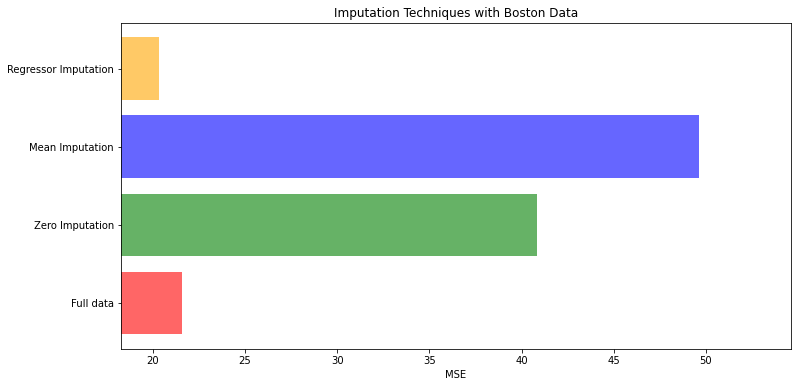

In [68]:
#绘制图形
x_labels = ['Full data',
            'Zero Imputation',
            'Mean Imputation',
            'Regressor Imputation']
colors = ['r', 'g', 'b', 'orange']

plt.figure(figsize=(12, 6))#画出画布
ax = plt.subplot(111)#plt.subplot添加子图，可以有多个

for i in np.arange(len(mse)):
    ax.barh(i, mse[i],color=colors[i], alpha=0.6, align='center')#横向条形图,条放在中间

ax.set_title('Imputation Techniques with Boston Data')
ax.set_xlim(left=np.min(mse) * 0.9, right=np.max(mse) * 1.1)#不让它从0开始
ax.set_yticks(np.arange(len(mse)))
ax.set_xlabel('MSE')
#ax.invert_yaxis()
#y轴反向

ax.set_yticklabels(x_labels)
plt.show()
#但是在训练数据上表现太好会有过拟合的风险